# NWDAF (Data) Analysis 

In [1]:
!wget https://raw.githubusercontent.com/sevgicansalih/nwdaf_data/master/nwdaf_data.csv

--2024-03-28 11:24:32--  https://raw.githubusercontent.com/sevgicansalih/nwdaf_data/master/nwdaf_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41050258 (39M) [text/plain]
Saving to: ‘nwdaf_data.csv’

nwdaf_data.csv      100%[===================>]  39.15M  7.97MB/s    in 5.9s    

2024-03-28 11:24:38 (6.62 MB/s) - ‘nwdaf_data.csv’ saved [41050258/41050258]



In [2]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import plotly.express as px
import plotly.subplots 
import kaleido

from IPython.core.display import SVG

## Visualisation of the features distributions

In [3]:
df = pd.read_csv( 'nwdaf_data.csv' )
df.info()
print( df.head() )
for col in df.columns: 
  v = df[ col ].unique()  
  print( f"   - {col} contains the following ({len( v )}) distinct values: {v}" )
print( "Evaluating the number of measurements per time values" )    
print( df.groupby( by=[ 't' ], sort=False ).agg( { 't' : 'count' } )[ 't' ] )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296000 entries, 0 to 1295999
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   t            1296000 non-null  int64  
 1   cell_id      1296000 non-null  int64  
 2   cat_id       1296000 non-null  int64  
 3   pe_id        1296000 non-null  int64  
 4   load         1296000 non-null  float64
 5   has_anomaly  1296000 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 59.3 MB
   t  cell_id  cat_id  pe_id       load  has_anomaly
0  0        0       0      0   4.997074            0
1  0        0       0      1  16.004322            0
2  0        0       0      2  52.985386            0
3  0        0       0      3   0.999767            0
4  0        0       0      4   5.000597            0
   - t contains the following (17280) distinct values: [    0     1     2 ... 17277 17278 17279]
   - cell_id contains the following (5) distinct values: [0 1 2 3 4]
 

The current dataframe contains an aggregation of measurements for all 'cell_id' *  'cat_id' * 'pe_id'. We reduce the data analysis to a single cell_id, cat_id, pe-id in order to get a single time value per measurement. 

In [17]:
## reduction 
cell_id = 0
cat_id = 0
pe_id = 0
df = df[ ( df.cell_id == cell_id ) & ( df.cat_id == cat_id ) & ( df.pe_id == pe_id ) ] 
df.head( )

,t,cell_id,cat_id,pe_id,load,has_anomaly
0,0,0,0,0,4.997074,0
75,1,0,0,0,4.997780,0
150,2,0,0,0,5.003721,1
225,3,0,0,0,5.002989,1
300,4,0,0,0,5.009872,1


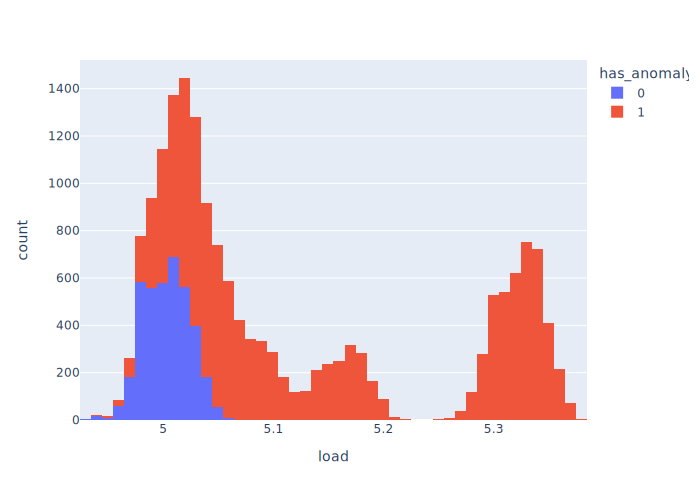

In [18]:
## specifically for load
fig = px.histogram( df, x='load', color='has_anomaly' )
svg_fn = 'feature_load_distribution.svg'
fig.write_image( svg_fn )
SVG(filename=svg_fn )

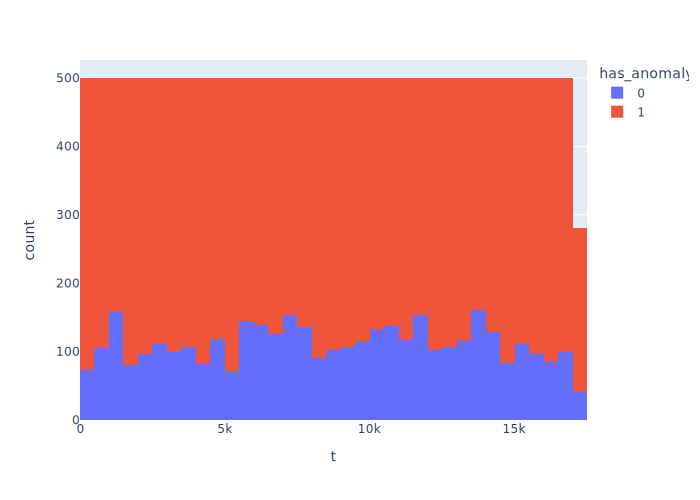

In [19]:
## specifically for time
fig = px.histogram( df, x='t', color='has_anomaly' )
svg_fn = 'feature_time_distribution.svg'
fig.write_image( svg_fn )
SVG(filename=svg_fn )

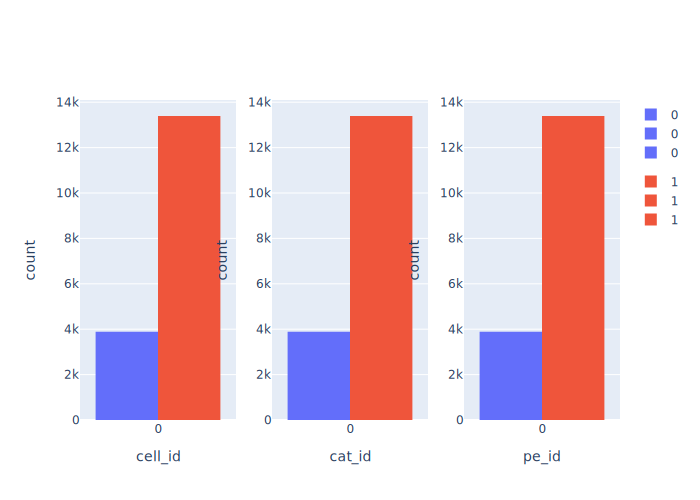

In [20]:
## others
subfig_list = [px.histogram( df, x=feature, color='has_anomaly' ) for feature in [ 'cell_id', 'cat_id', 'pe_id' ] ]

fig = plotly.subplots.make_subplots( rows=1, cols=len(subfig_list) )
for subfig in subfig_list :  
  xaxis_title_text = subfig[ 'layout' ][ 'xaxis' ][ 'title' ][ 'text' ]
  yaxis_title_text = subfig[ 'layout' ][ 'yaxis' ][ 'title' ][ 'text' ]
  col = subfig_list.index( subfig ) + 1    
  for trace in range(len(subfig["data"])):
    fig.add_trace( subfig["data"][trace], row=1, col= col )
    fig.update_xaxes( title_text=xaxis_title_text, row=1, col=col )
    fig.update_yaxes( title_text=yaxis_title_text, row=1, col=col )
fig.write_image( 'feature_distribution.svg')
SVG(filename='feature_distribution.svg')
 

## PCA


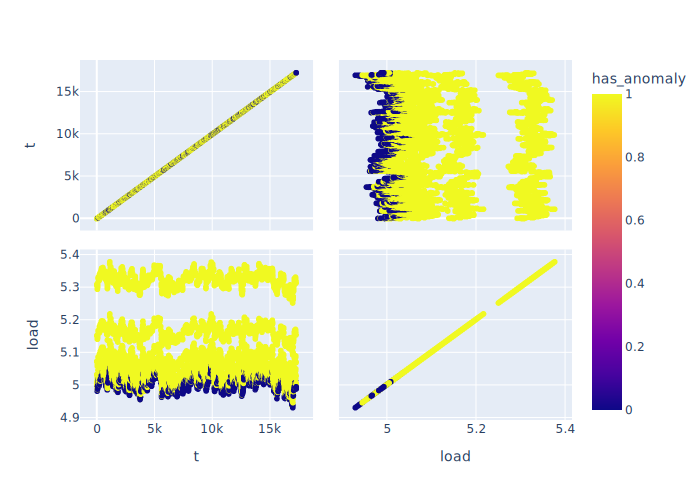

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import numpy as np

## the full df
X = df[ ['t',  'cell_id', 'cat_id', 'pe_id', 'load'] ]
## removing columns
X = df[ ['t', 'load'] ]

Target = df[ [ 'has_anomaly' ] ]
x_scaled = StandardScaler().fit_transform(X)
scaled_df = pd.DataFrame.from_records( x_scaled )
scaled_df[ 'has_anomaly' ] = Target
fig = px.scatter_matrix(df,
    dimensions=X.columns,
    color="has_anomaly")
svg_fn = "features_normalized_scatter.svg"  
fig.write_image( svg_fn )
SVG(filename=svg_fn)  

## PCA Dimension reduction

In [23]:
def characterize_pca( X, filename="" ):
  pca = PCA(n_components=len( X.columns ) )
  pca.fit( X ) # scaling
  X_pca = pca.transform(X)
  print(f"PCA Components (~base): {pca.components_}")
  print(f"PCA Explained Variance (~length): {pca.explained_variance_}")
  print(f"PCA Explained Variance ratio: {pca.explained_variance_ratio_}")

  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance');
#  plt.show()
  svg_fn = f"{filename}_pca_dimension.svg"  
  plt.savefig( svg_fn )
#  SVG(filename=svg_fn) 
    
  X_new = pca.inverse_transform(X_pca)
  #print( X_new )
  new_df = pd.DataFrame.from_records( X_new )
  dim = new_df.columns
  new_df[ 'has_anomaly' ] = Target
  #print( new_df.head ) 
  fig = px.scatter_matrix(new_df,
    dimensions=dim,
    color="has_anomaly")
#  fig.show()
  svg_fn = f"{filename}_pca_scatter.svg"  
  fig.write_image( svg_fn )
#  SVG(filename=svg_fn)  

PCA Components (~base): [[ 1.00000000e+00 -4.85702041e-07]
 [ 4.85702041e-07  1.00000000e+00]]
PCA Explained Variance (~length): [2.4884640e+07 1.7136686e-02]
PCA Explained Variance ratio: [9.99999999e-01 6.88645124e-10]


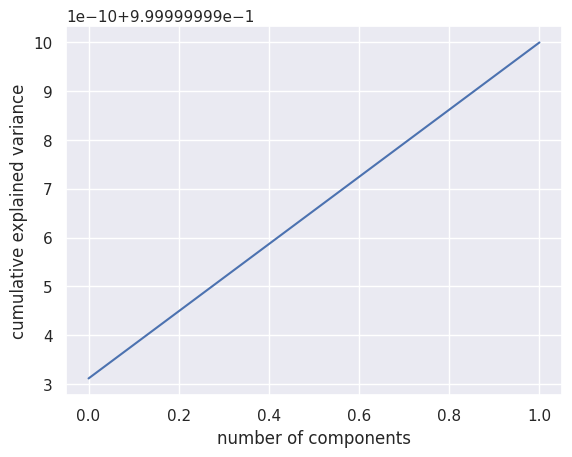

In [24]:
#taking all features
#characterize_pca( df[ ['t',  'cell_id', 'cat_id', 'pe_id', 'load'] ] , filename='all_features' )
characterize_pca( df[ ['t', 'load'] ] , filename='all_features' )

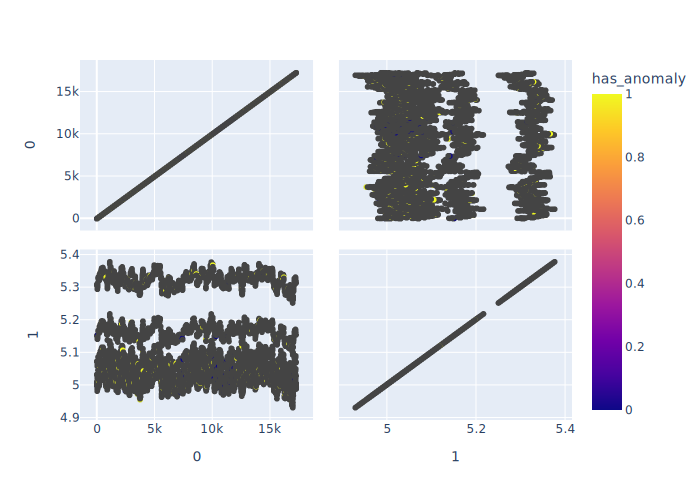

In [25]:
SVG('./all_features_pca_scatter.svg' )

PCA Components (~base): [[1.]]
PCA Explained Variance (~length): [0.01714256]
PCA Explained Variance ratio: [1.]


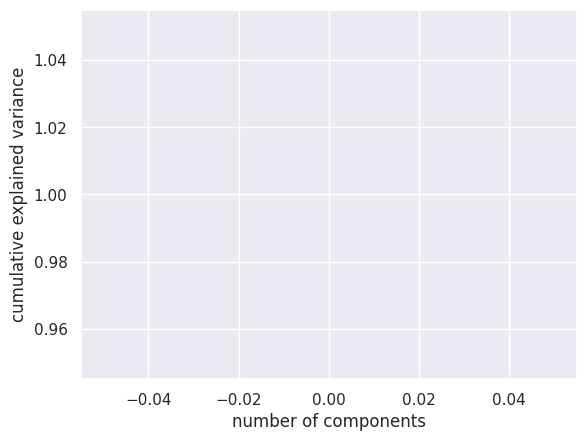

In [26]:
# removing 't'
# characterize_pca( df[ [ 'cell_id', 'cat_id', 'pe_id', 'load' ] ], filename="no_t" )
characterize_pca( df[ [ 'load' ] ], filename="no_t" )

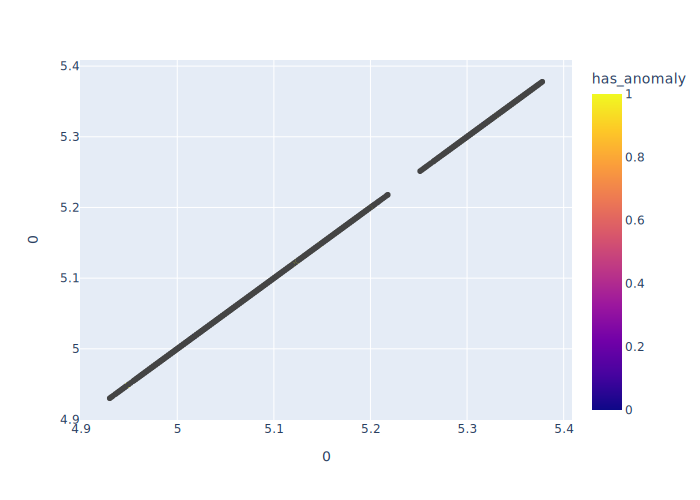

In [27]:
SVG('./no_t_pca_scatter.svg' )

# Time Related feature with skforecast: Recursive multi-step forecasting with RandomForestRegressor

[skforecast](https://skforecast.org/0.11.0/index.html#examples-and-tutorials)

## Preparing the Data

In [1]:
import time_series_utils as tu
import pandas as pd

## Selecting aand formating a subset of the data
cell_id=0
cat_id=0 
pe_id=0 

df = tu.format_data_set( tu.data_subset( cell_id=cell_id,
                                   cat_id=cat_id, 
                                    pe_id=pe_id ) )

print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

# Verify that a temporary index is complete
complete = (df.index == pd.date_range(start=df.index.min(),
                             end=df.index.max(),
                             freq=df.index.freq)).all()

if complete :
  print( "Temporary index is complete") 
else: 
  raise ValueError( "Temporary index is not complete") 
    
df.info()
df.head()



Number of rows with missing values: 0.0
Temporary index is complete
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17280 entries, 2024-01-01 00:00:00 to 2024-01-01 04:47:59
Freq: S
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   17280 non-null  int64  
 1   load    17280 non-null  float64
 2   y       17280 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 540.0 KB


,index,load,y
date,,,
2024-01-01 00:00:00,0,4.997074,0
2024-01-01 00:00:01,75,4.997780,0
2024-01-01 00:00:02,150,5.003721,1
2024-01-01 00:00:03,225,5.002989,1
2024-01-01 00:00:04,300,5.009872,1


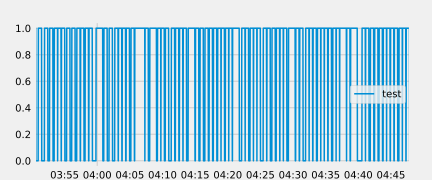

In [2]:
## 20 % of measurements will be considered for testing,
test_ratio = 20

## showing training / testing set
tu.SVG( filename=tu.plot_train_test( df, test_ratio=20 ) )



The following lines helps us in understanding what is lags values needs to be considered. Applying the grid_search_forecaster function provided very high values for lag (1736) which are considered too high. Typically 1736 might be the most optimnal value but having a lag of 20 might provide an acceptable accuracy. In such case, we might balance the cost of using 1736 versus using 20 and have much faster predictions.

The function below intend to figure out what are the costs and benefits associated to the lag values.

Our prediction is not a real value but instead '0' or '1'. As a result, the predictions provided by the model needs to be set to [ 0, 1 ] using a threshold value. We define a function that is able to provide the threshold that minimizes the error as well as plot predictions provided from the model and once the threshold has been applied.

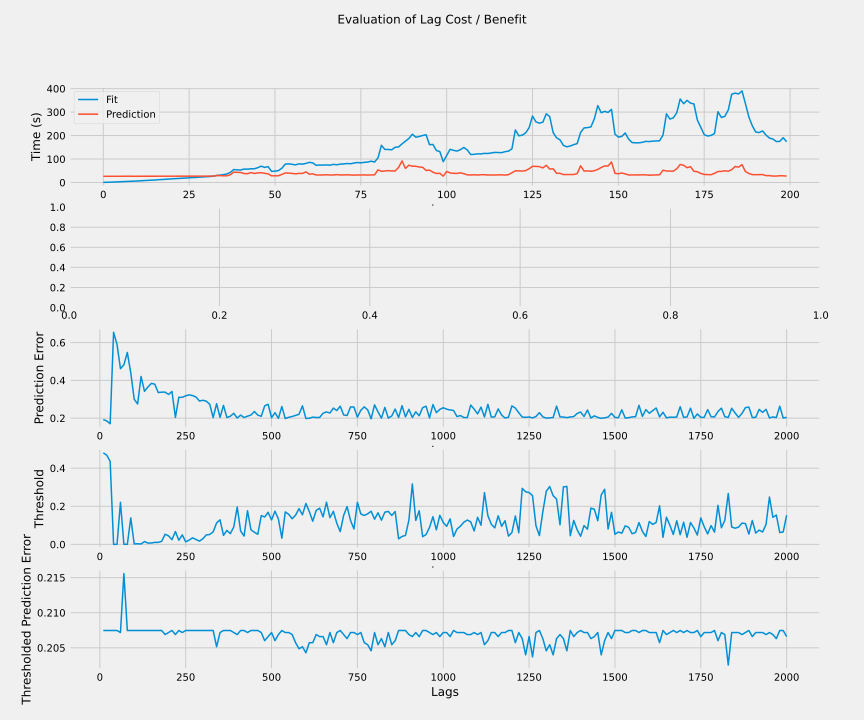

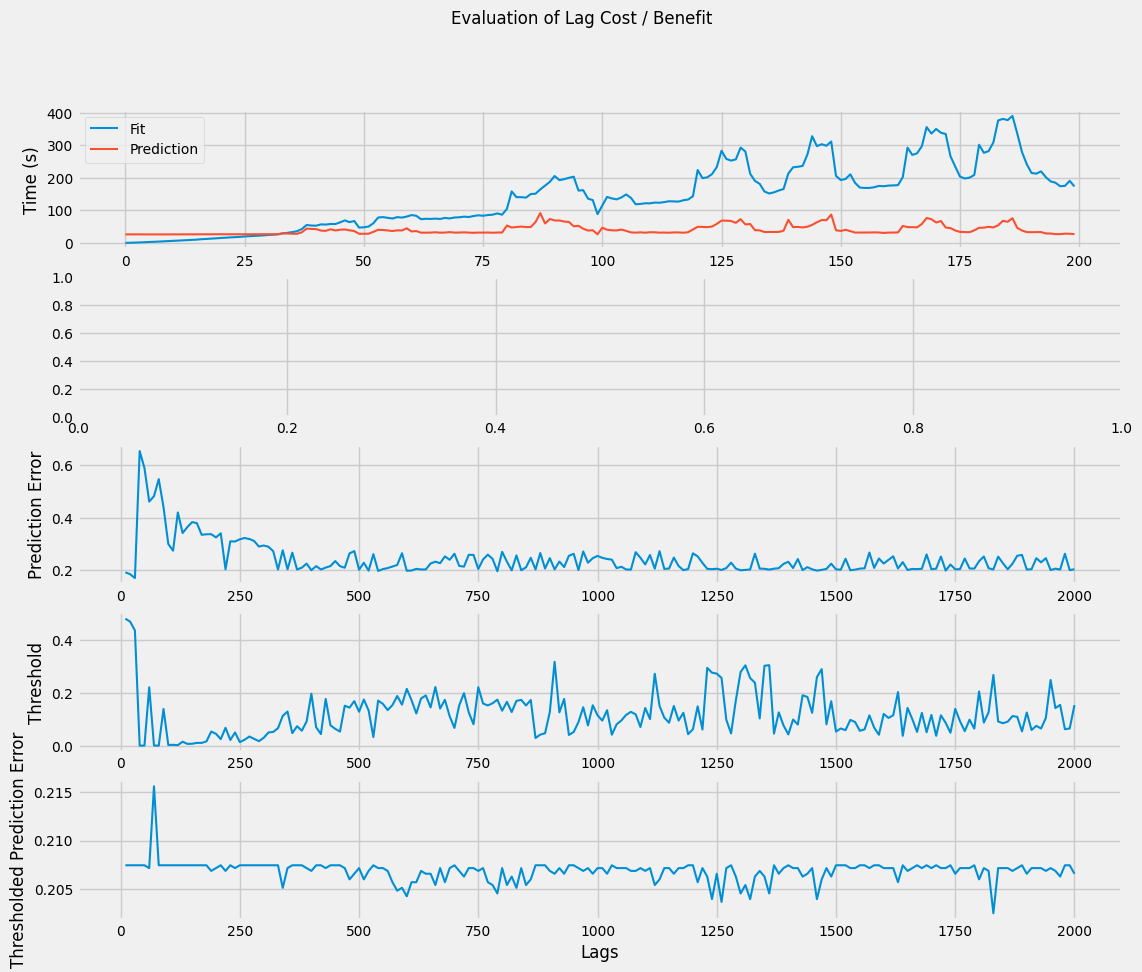

In [3]:
## lag is an important parameter for time series. We will 
## estimate the cost / benefit over using a shorter lag value
## evcen if non optimal.

lag_min = 10
lag_max = 2000
lag_step = 10

threshold_min = 0
threshold_max = 1
threshold_step = 0.001

regressor = tu.RandomForestRegressor(\
              random_state=123,
              n_estimators=100,
              max_depth=10 )

## evaluating the impact of lag
tu.SVG( filename=tu.plot_lag_evaluation( df, regressor, lag_min, lag_max, lag_step, \
    threshold_min=threshold_min, threshold_max=threshold_max, threshold_step=threshold_step,
    test_ratio=20 ) )



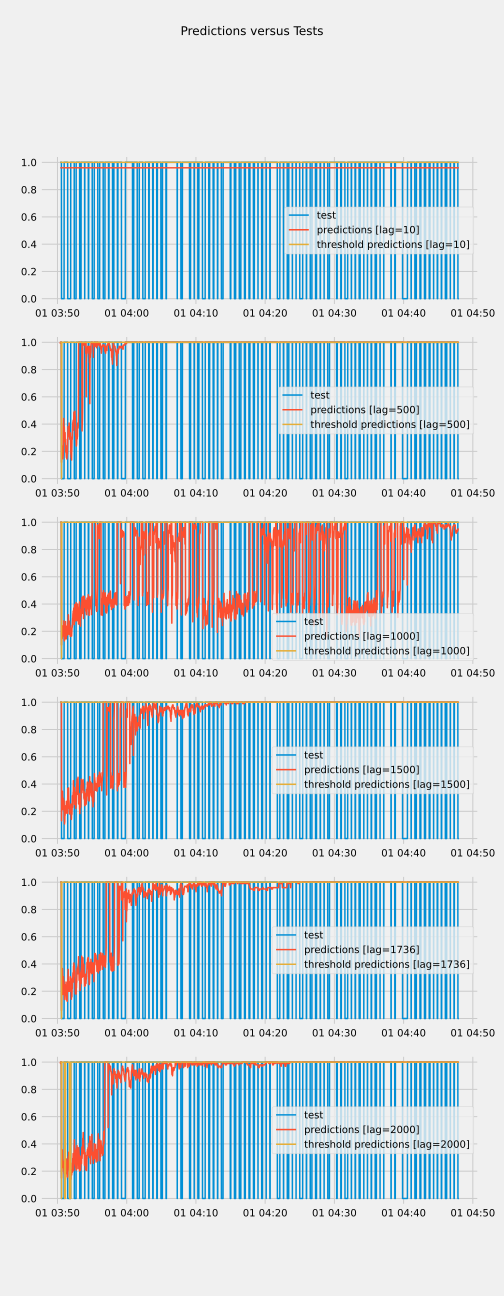

In [21]:
## ploting distributions for given lag values
plot_lag_list=[10, 500, 1000, 1500, 1736, 2000 ]

tu.SVG( filename=tu.plot_lag_predictions( df, regressor, plot_lag_list, \
    threshold_min=threshold_min, threshold_max=threshold_max, threshold_step=threshold_step,
    test_ratio=20 ) )


### Hyperparameter tuning

In [25]:
# Hyperparameter grid search
# ==============================================================================

forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
#lags_grid = [ int( 0.1 * steps), int( 0.5 * steps), int( 1 * steps) ]
lags_grid = [ 1728 ]

print( f"checking if lags are smaller than the series: {steps}" )
for lags in lags_grid:
  if lags > steps:
    raise ValueError( "The maximum lag ({lags}) must be less than the length of the series ({steps})." )      

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [ 100 ],
    'max_depth': [10, 20, 50 ]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = int( len( data_test ) ),
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )


checking if lags are smaller than the series: 3456
Number of models compared: 3.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [   1    2    3 ... 1726 1727 1728] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.24352156864601796



In [26]:
# Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.243522,10,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 100}",0.254913,20,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 50, 'n_estimators': 100}",0.254913,50,100


In [27]:
## Since we have set return_best to True, we do not really need to perform this task.
##
# Create and train forecaster with the best hyperparameters
# ==============================================================================
## Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
##  Lags: [   1    2    3 ... 1726 1727 1728] 
##  Parameters: {'max_depth': 5, 'n_estimators': 100}
##  Backtesting metric: 0.29134653972849744

#regressor = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=123)
#forecaster = ForecasterAutoreg(
#                regressor = regressor,
#                lags      = 1728
#             )
#
# forecaster.fit(y=data_train['y'])


In [28]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=test_len)

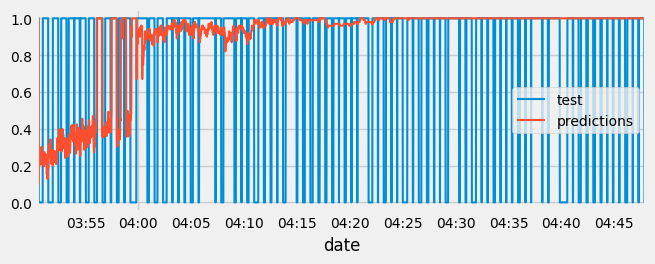

In [29]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
#data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Time Related feature with skforecast: Recursive multi-step forecasting with Linear Regressor